## Telecom Churn Prediction with PySpark
**Author: Runqi Liu**
</br>
**Data Source: [kaggle](https://www.kaggle.com/datasets/mnassrib/telecom-churn-datasets?datasetId=255093&sortBy=voteCount)**
</br>
Telecom churn prediction is a critical task in the telecommunications industry. By identifying customers who are likely to churn (i.e., switch to a competitor), telecom companies can take proactive measures to retain those customers and minimize revenue loss. In this project, I used PySpark and machine learning to build and evaluate churn prediction models.

### Import libaries and prepare data

In [1]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# create a SparkSession and load training and testing data
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("churnPrediction").config("spark.driver.random.seed", 123).getOrCreate()

In [4]:
train = spark.read.csv('churn-bigml-80.csv', header='true', inferSchema='true')
test = spark.read.csv('churn-bigml-20.csv', header='true', inferSchema='true')
# schema of dataset
train.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [5]:
print("The training dataset contains {} samples.".format(train.count()))
print("The test dataset contains {} samples.".format(test.count()))

The training dataset contains 2666 samples.
The test dataset contains 667 samples.


In [6]:
# show top 5 rows
train.show(5, truncate=False)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|KS 

In [7]:
# convert 'International plan', 'Voice mail plan', 'Churn' to binary
train = train.withColumn('International plan', when(col('International plan')=="Yes", 1).otherwise(0))
train = train.withColumn('Voice mail plan', when(col('Voice mail plan')=="Yes", 1).otherwise(0))
train = train.withColumn('Churn', when(col('Churn'), 1).otherwise(0))

In [8]:
# do the same for test data
test = test.withColumn('International plan', when(col('International plan')=="Yes", 1).otherwise(0))
test = test.withColumn('Voice mail plan', when(col('Voice mail plan')=="Yes", 1).otherwise(0))
test = test.withColumn('Churn', when(col('Churn'), 1).otherwise(0))

In [9]:
train.show(5, truncate=False)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|KS 

### Exploratory Analysis

In [10]:
# summary statistics
numeric_features = [t[0] for t in train.dtypes if t[1] == 'int' or t[1] == 'double']
train.describe(numeric_features).toPandas()

,summary,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,count,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666
1,mean,100.62040510127532,437.43885971492875,0.10127531882970743,0.27494373593398347,8.021755438859715,179.48162040510135,100.31020255063765,30.512404351087813,200.38615903976006,100.02363090772693,17.033072018004518,201.16894223555968,100.10615153788447,9.052689422355604,10.23702175543886,4.467366841710428,2.764489872468112,1.5626406601650413,0.145536384096024
2,stddev,39.56397365334985,42.521018019427174,0.3017495351400154,0.44656968200461133,13.61227701829193,54.21035022086982,19.988162186059512,9.215732907163497,50.95151511764598,20.16144511531889,4.330864176799864,50.780323368725206,19.418458551101697,2.2851195129157564,2.7883485770512566,2.4561949030129466,0.7528120531228477,1.3112357589949093,0.3527069711441949
3,min,1,408,0,0,0,0.0,0,0.0,0.0,0,0.0,43.7,33,1.97,0.0,0,0.0,0,0
4,max,243,510,1,1,50,350.8,160,59.64,363.7,170,30.91,395.0,166,17.77,20.0,20,5.4,9,1


No missing values are found. 14.6% customers in the training data churned

In [11]:
# correlation matrix
train_numeric = train.select(numeric_features)
train_numeric.toPandas().corr()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
Account length,1.000000,-0.008620,0.024500,0.002448,-0.002996,0.002847,0.038862,0.002843,-0.015923,0.018552,-0.015909,-0.008994,-0.024007,-0.008999,0.011369,0.017627,0.011383,0.002455,0.017728
Area code,-0.008620,1.000000,0.047099,0.007180,-0.000584,-0.023134,-0.009629,-0.023130,0.000679,-0.018602,0.000707,-0.003353,0.011455,-0.003382,-0.013418,-0.027423,-0.013534,0.034442,0.001019
International plan,0.024500,0.047099,1.000000,0.002131,0.005858,0.049550,-0.004277,0.049555,0.026616,0.010277,0.026623,-0.010310,0.018081,-0.010316,0.053162,0.011549,0.053037,-0.035955,0.277489
Voice mail plan,0.002448,0.007180,0.002131,1.000000,0.957159,0.013438,-0.007541,0.013439,0.019132,0.003404,0.019147,0.001065,0.013985,0.001066,-0.013963,0.015196,-0.013931,-0.022054,-0.099291
Number vmail messages,-0.002996,-0.000584,0.005858,0.957159,1.000000,0.019027,-0.009622,0.019027,0.011401,0.005131,0.011418,-0.000224,0.008124,-0.000229,-0.004156,0.027013,-0.004136,-0.018787,-0.086474
Total day minutes,0.002847,-0.023134,0.049550,0.013438,0.019027,1.000000,0.016780,1.000000,0.003999,0.009059,0.003992,0.013491,0.015054,0.013464,-0.011042,0.005687,-0.010934,-0.024543,0.195688
Total day calls,0.038862,-0.009629,-0.004277,-0.007541,-0.009622,0.016780,1.000000,0.016787,-0.026003,0.006473,-0.026006,0.008986,-0.016776,0.008972,0.031036,0.006928,0.031133,-0.011945,0.018290
Total day charge,0.002843,-0.023130,0.049555,0.013439,0.019027,1.000000,0.016787,1.000000,0.004008,0.009056,0.004002,0.013495,0.015057,0.013468,-0.011046,0.005688,-0.010938,-0.024548,0.195689
Total eve minutes,-0.015923,0.000679,0.026616,0.019132,0.011401,0.003999,-0.026003,0.004008,1.000000,-0.007654,1.000000,-0.013414,0.009017,-0.013450,-0.006915,0.002160,-0.006947,-0.013192,0.072906
Total eve calls,0.018552,-0.018602,0.010277,0.003404,0.005131,0.009059,0.006473,0.009056,-0.007654,1.000000,-0.007642,-0.000175,0.000797,-0.000135,0.011012,0.003710,0.011000,0.001058,-0.001539


<AxesSubplot:>

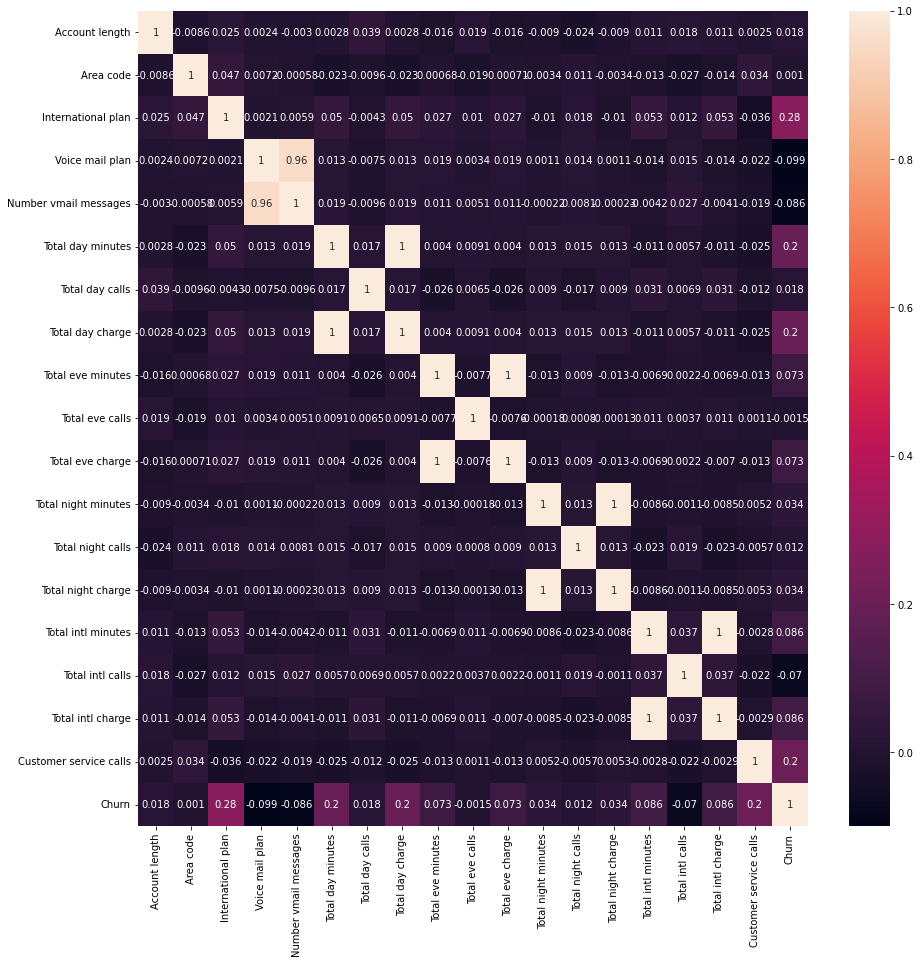

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(train_numeric.toPandas().corr(),annot=True)

In [13]:
# note that 'Area code' is not a numeric variable but categorical variable
#churn by area code
train.createOrReplaceTempView("train_temp")
churn_by_area = spark.sql("""
    SELECT `Area code`, AVG(Churn) AS MeanChurn, COUNT(*) AS TotalRecord
    FROM train_temp
    GROUP BY `Area code`
""")
churn_by_area.show()

+---------+-------------------+-----------+
|Area code|          MeanChurn|TotalRecord|
+---------+-------------------+-----------+
|      415| 0.1479514415781487|       1318|
|      510|0.14580265095729014|        679|
|      408|0.14050822122571002|        669|
+---------+-------------------+-----------+



In [14]:
# churn rates across area codes are similar, so will not include area codes for churn prediction

<AxesSubplot:>

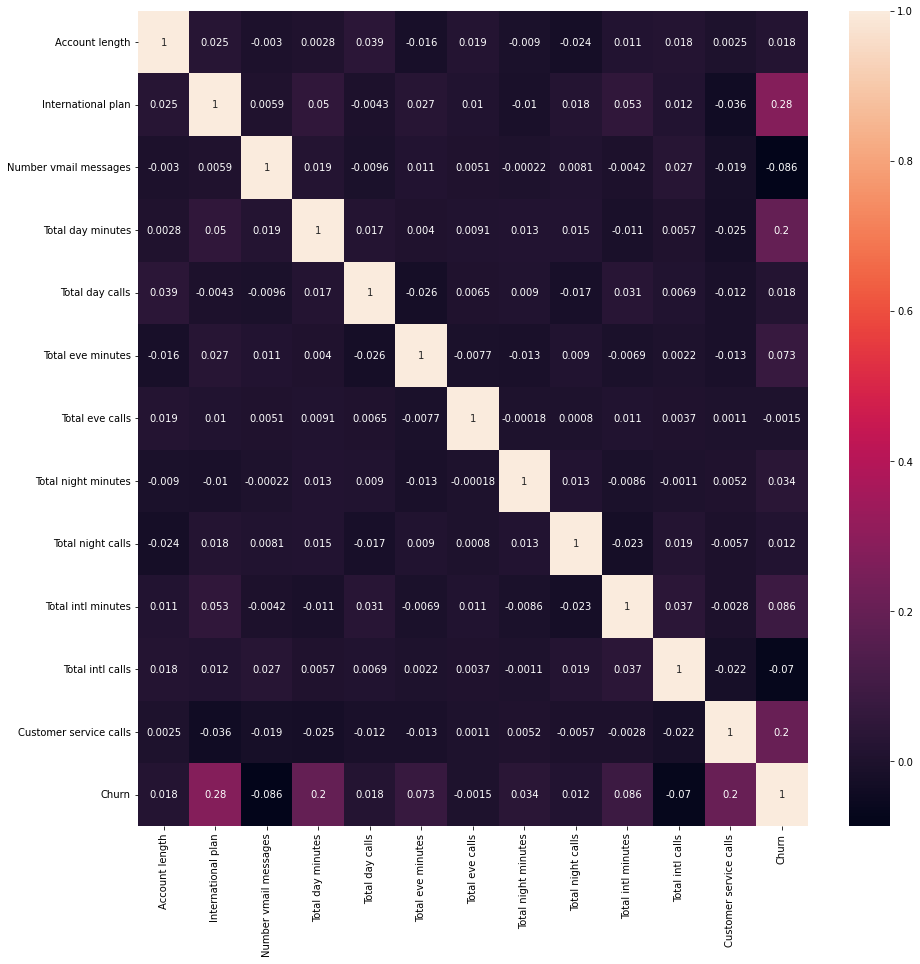

In [15]:
# delete variables 'Voice mail plan','Total day charge','Total eve charge','Total night charge','Total intl charge' to avoid collinearity
selected_variables = ["`Account length`", "`International plan`",
                      "`Number vmail messages`", "`Total day minutes`", "`Total day calls`",
                      "`Total eve minutes`", "`Total eve calls`",
                      "`Total night minutes`", "`Total night calls`",
                      "`Total intl minutes`", "`Total intl calls`",
                      "`Customer service calls`","Churn"]
train_numeric = train.select(selected_variables)

plt.figure(figsize=(15,15))
sns.heatmap(train_numeric.toPandas().corr(),annot=True)


In [16]:
# churn rates by state
train.createOrReplaceTempView("train_temp")
churn_by_state = spark.sql("""
    SELECT State, AVG(Churn) AS MeanChurn, COUNT(*) AS TotalRecord
    FROM train_temp
    GROUP BY State
    ORDER BY MeanChurn DESC
""")
churn_by_state.show(60)

+-----+--------------------+-----------+
|State|           MeanChurn|TotalRecord|
+-----+--------------------+-----------+
|   TX|  0.2909090909090909|         55|
|   NJ|                0.28|         50|
|   AR| 0.23404255319148937|         47|
|   MD| 0.23333333333333334|         60|
|   MS| 0.22916666666666666|         48|
|   ME| 0.22448979591836735|         49|
|   SC| 0.22448979591836735|         49|
|   MI| 0.22413793103448276|         58|
|   PA|  0.2222222222222222|         36|
|   NV| 0.21311475409836064|         61|
|   NH| 0.20930232558139536|         43|
|   CA| 0.20833333333333334|         24|
|   WA| 0.20833333333333334|         48|
|   KS| 0.19230769230769232|         52|
|   MT| 0.18867924528301888|         53|
|   CT|  0.1864406779661017|         59|
|   MN| 0.18571428571428572|         70|
|   NY| 0.17647058823529413|         68|
|   GA| 0.16326530612244897|         49|
|   NC| 0.16071428571428573|         56|
|   DE|  0.1568627450980392|         51|
|   MA| 0.153846

In [17]:
# Convert 'State' to binary variables
states = train.select("State").distinct().rdd.flatMap(lambda x: x).collect()
# Convert 'state' values into dummy variables
train = train.select("*", *[when(col("State") == state, 1).otherwise(0).alias(state) for state in states])

# Show the resulting new columns for each state
train.show(5, truncate=False)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|AZ |SC |LA |MN |NJ |DC |OR |VA |RI |WY |KY |NH |MI |NV |WI |ID |CA |NE |CT |MT |NC |VT |MD |DE |MO |IL |ME |WA |ND |MS |AL |IN |OH |T

In [18]:
test = test.select("*", *[when(col("State") == state, 1).otherwise(0).alias(state) for state in states])

In [19]:
# churn rates by international plan
train.createOrReplaceTempView("train_temp")
churn_by_intl_plan = spark.sql("""
    SELECT `international plan`, AVG(Churn) AS MeanChurn
    FROM train_temp
    GROUP BY `international plan`
""")
churn_by_intl_plan.show()

+------------------+-------------------+
|international plan|          MeanChurn|
+------------------+-------------------+
|                 1|0.43703703703703706|
|                 0|0.11268781302170283|
+------------------+-------------------+



The users with international plan are more likely to churn

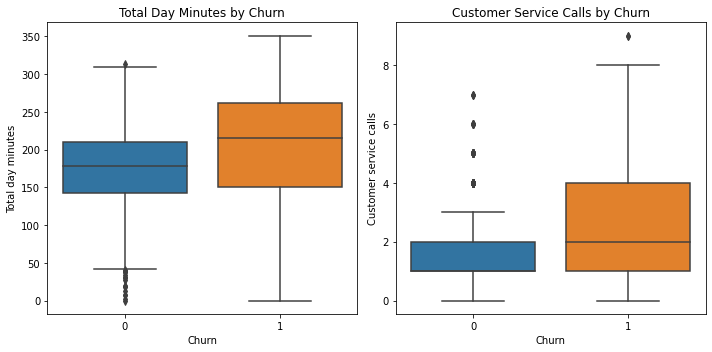

In [20]:
# churn rates by total day minutes, customer service calls

columns = ['Churn', 'Total day minutes', 'Customer service calls']
data = train.select(columns).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot for Total day minutes by churn
sns.boxplot(x='Churn', y='Total day minutes', data=data, ax=axes[0])
axes[0].set_title('Total Day Minutes by Churn')

# Boxplot for Customer service calls by churn
sns.boxplot(x='Churn', y='Customer service calls', data=data, ax=axes[1])
axes[1].set_title('Customer Service Calls by Churn')

plt.tight_layout()
plt.show()


One average, the churning users spend more time on day calls and make more customer service calls

### Modelling

In [21]:
# Prepare feature vector
selectedFeatures = ["Account length", "International plan",
                    "Number vmail messages", "Total day minutes", "Total day calls",
                    "Total eve minutes", "Total eve calls",
                    "Total night minutes", "Total night calls",
                    "Total intl minutes", "Total intl calls",
                    "Customer service calls"] + states
assembler = VectorAssembler(
    inputCols= selectedFeatures,
    outputCol="features"
)
train = assembler.transform(train)
test = assembler.transform(test)

In [22]:
# fit models and predict on test data

# Logistic Regression
lr = LogisticRegression(labelCol="Churn")
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)

# Random Forest
rf = RandomForestClassifier(labelCol="Churn")
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

# Decision Tree
dt = DecisionTreeClassifier(labelCol="Churn")
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)

# Gradient-Boosted Tree
gbt = GBTClassifier(labelCol="Churn")
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)

In [23]:
# model evaluation

auc_evaluator = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderROC')
classification_evaluator = MulticlassClassificationEvaluator(labelCol='Churn')

# Calculate the evaluation metrics for each model
auc_scores = {
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 'Gradient-Boosted Tree'],
    'AUC': []
}

classification_scores = {
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 'Gradient-Boosted Tree'],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for model_name, predictions in zip(['Logistic Regression', 'Random Forest', 'Decision Tree', 'Gradient-Boosted Tree'], [lr_predictions, rf_predictions, dt_predictions, gbt_predictions]):
    # Calculate AUC
    auc = auc_evaluator.evaluate(predictions)
    auc_scores['AUC'].append(auc)
    
    # Calculate accuracy
    accuracy = classification_evaluator.evaluate(predictions, {classification_evaluator.metricName: 'accuracy'})
    classification_scores['Accuracy'].append(accuracy)
    
    # Calculate precision
    precision = classification_evaluator.evaluate(predictions, {classification_evaluator.metricName: 'weightedPrecision'})
    classification_scores['Precision'].append(precision)
    
    # Calculate recall
    recall = classification_evaluator.evaluate(predictions, {classification_evaluator.metricName: 'weightedRecall'})
    classification_scores['Recall'].append(recall)
    
    # Calculate F1-score
    f1_score = classification_evaluator.evaluate(predictions, {classification_evaluator.metricName: 'f1'})
    classification_scores['F1-Score'].append(f1_score)

auc_scores_df = spark.createDataFrame(pd.DataFrame(auc_scores))
classification_scores_df = spark.createDataFrame(pd.DataFrame(classification_scores))

# Display the evaluation metrics tables
auc_scores_df.show()
classification_scores_df.show()

+--------------------+-------------------+
|               Model|                AUC|
+--------------------+-------------------+
| Logistic Regression| 0.8032572690467418|
|       Random Forest| 0.8947736474052267|
|       Decision Tree|0.24561096797938906|
|Gradient-Boosted ...| 0.9310544718439452|
+--------------------+-------------------+

+--------------------+------------------+------------------+------------------+------------------+
|               Model|          Accuracy|         Precision|            Recall|          F1-Score|
+--------------------+------------------+------------------+------------------+------------------+
| Logistic Regression|0.8605697151424287|0.8338342905841766|0.8605697151424287|0.8392058719084394|
|       Random Forest|0.8575712143928036| 0.735428387755148|0.8575712143928036| 0.791817166477294|
|       Decision Tree|0.9445277361319341|0.9449697181881695|0.9445277361319341|0.9398518243888895|
|Gradient-Boosted ...|0.9535232383808095| 0.952776346433228|0

The Gradient-Boosted Tree model has the best overall performance

Improve the Grandient-Boosted Tree model- Hyper-parameter tuning

In [25]:
# Get all the parameters of the current model
params = gbt_model.extractParamMap()

for param in params:
    print(param.name, ": ", params[param])

cacheNodeIds :  False
checkpointInterval :  10
featureSubsetStrategy :  all
featuresCol :  features
impurity :  variance
labelCol :  Churn
leafCol :  
lossType :  logistic
maxBins :  32
maxDepth :  5
maxIter :  20
maxMemoryInMB :  256
minInfoGain :  0.0
minInstancesPerNode :  1
minWeightFractionPerNode :  0.0
predictionCol :  prediction
probabilityCol :  probability
rawPredictionCol :  rawPrediction
seed :  -8273189711654273496
stepSize :  0.1
subsamplingRate :  1.0
validationTol :  0.01


In [29]:
# Create a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 7]) \
    .addGrid(gbt.maxBins, [32, 64]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .build()

# Define the evaluation metric
evaluator = BinaryClassificationEvaluator(labelCol="Churn", metricName="areaUnderROC")

# Create a CrossValidator with 5-fold cross-validation
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          seed=1234)

# Train the model using the CrossValidator
cvModel = crossval.fit(train)

# Get the best model
bestModel = cvModel.bestModel

# Print the best model's hyperparameters
bestParams = bestModel.extractParamMap()

for param in bestParams:
    print(param.name, ": ", bestParams[param])

cacheNodeIds :  False
checkpointInterval :  10
featureSubsetStrategy :  all
featuresCol :  features
impurity :  variance
labelCol :  Churn
leafCol :  
lossType :  logistic
maxBins :  32
maxDepth :  5
maxIter :  30
maxMemoryInMB :  256
minInfoGain :  0.0
minInstancesPerNode :  1
minWeightFractionPerNode :  0.0
predictionCol :  prediction
probabilityCol :  probability
rawPredictionCol :  rawPrediction
seed :  -8273189711654273496
stepSize :  0.1
subsamplingRate :  1.0
validationTol :  0.01


In [30]:
# Make predictions on the test data using the best model
predictions = bestModel.transform(test)

# Evaluate the model performance
auc = evaluator.evaluate(predictions)
accuracy = predictions.filter(predictions.Churn == predictions.prediction).count() / float(predictions.count())

# Print evaluation metrics
print("AUC:", auc)
print("Accuracy:", accuracy)

AUC: 0.9305207949944782
Accuracy: 0.9625187406296851


### Feature Importance

In [28]:
# Get feature importance scores
feature_importances = bestModel.featureImportances

feature_scores = {feature: score for feature, score in zip(train.columns, feature_importances)}
selected_feature_scores = {feature: score for feature, score in feature_scores.items() if feature in selectedFeatures}

# Sort the feature scores in descending order
sorted_feature_scores = sorted(selected_feature_scores.items(), key=lambda x: x[1], reverse=True)

# Display the top features with their importance scores
for feature, score in sorted_feature_scores[:10]:
    print(f"{feature}: {score}")

International plan: 0.23653693465212197
Number vmail messages: 0.19703390173747873
Total day calls: 0.08822975082412698
Total eve minutes: 0.07806285464829744
Total eve calls: 0.07036454777274749
Account length: 0.06455042628800636
Total day minutes: 0.010151324641516319
VT: 0.009241308218050932
Customer service calls: 0.005564374743551215
IN: 0.005461506631104356
